In [2]:
from sklearn.metrics import confusion_matrix, r2_score, mean_squared_error, mean_absolute_error
import json
import time
import math
import numpy as np
import pandas as pd
from rxnfp.models import SmilesClassificationModel
import torch 
import matplotlib.pyplot as plt
import argparse

In [14]:
def plot_model(ax, y_true, y_predicted, title, l):
    rmse = np.sqrt(mean_squared_error(y_true, y_predicted))
    r2 = r2_score(y_true, y_predicted)

    # Plot the data
    ax.scatter(y_true, y_predicted, color='teal', label=l, alpha=0.8)

    # Plot the diagonal line
    ax.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='black', linestyle='--')

    # Plot the fitting line
    fitting_line = np.polyfit(y_true, y_predicted, 1)
    ax.plot(y_true, np.polyval(fitting_line, y_true), color='r')

    # Set labels and title
#    ax.set_xlabel('True Values', fontsize=12)
#    ax.set_ylabel('Predicted Values', fontsize=12)
#    ax.set_title(f'{dataset_train}_{dataset_test}')

    # Display RMSE and R2 coefficients in the plot
    text = f'RMSE: {rmse:.2f}\nR2: {r2:.2f}'
    props = dict(boxstyle='round', facecolor='white', edgecolor='black', alpha=0.8)
    ax.text(0.6, 0.1, text, transform=ax.transAxes, fontsize=12, bbox=props)

In [4]:
def epochs_calc_r2(df, model_dir, checkpoint_multiple, epoch_offset, final_epoch, stride, mean, std):
    i=final_epoch
    
    model_path = model_dir + f"/checkpoint-{i*checkpoint_multiple}-epoch-{i}"
    trained_yield_bert = SmilesClassificationModel('bert', model_path, num_labels=1, args={"regression": True}, use_cuda=torch.cuda.is_available())

    lcms_predicted = trained_yield_bert.predict(df.text.values)[0]
    lcms_predicted = lcms_predicted * std + mean
    lcms_true = df.labels.values
    lcms_true = lcms_true * std + mean

    return lcms_true, lcms_predicted

In [5]:
df_us = pd.read_csv('../../data/df_us_rxnfp.csv')
df_rx = pd.read_csv('../../data/df_rx_rxnfp.csv')
df_hte = pd.read_csv('../../data/df_hte_rxnfp.csv')
df_az = pd.read_csv('../../data/df_az_rxnfp.csv')

In [6]:
delimiter = '.'
df_us['rxn'] = df_us.apply(lambda row: delimiter.join(row[['CONDITIONS', 'NO_MAP_NO_COND']]), axis=1)
df_us.dropna(subset = ['rxn'], inplace=True)
df_rx['rxn'] = df_rx.apply(lambda row: delimiter.join(row[['CONDITIONS', 'NO_MAP_NO_COND']]), axis=1)
df_rx.dropna(subset = ['rxn'], inplace=True)
df_hte['rxn'] = df_hte.apply(lambda row: delimiter.join(row[['CONDITIONS', 'NO_MAP_NO_COND']]), axis=1)
df_hte.dropna(subset = ['rxn'], inplace=True)
df_az['rxn'] = df_az.apply(lambda row: delimiter.join(row[['CONDITIONS', 'NO_MAP_NO_COND']]), axis=1)
df_az.dropna(subset = ['rxn'], inplace=True)

In [8]:
train_df_us=df_us.sample(frac=0.8,random_state=200)
val_test=df_us.drop(train_df_us.index)
val_df_us = val_test.iloc[int(len(val_test)/2):]
test_df_us = val_test.iloc[:int(len(val_test)/2)]

train_df_us = train_df_us[['rxn', 'YIELD']] 
test_df_us = test_df_us[['rxn', 'YIELD']] #
val_df_us = val_df_us[['rxn', 'YIELD']]

train_df_us.columns = ['text', 'labels']
test_df_us.columns = ['text', 'labels']
val_df_us.columns = ['text', 'labels']


mean = train_df_us.labels.mean()
std = train_df_us.labels.std()

train_df_us['labels'] = (train_df_us['labels'] - mean) / std
test_df_us['labels'] = (test_df_us['labels'] - mean) / std
val_df_us['labels'] = (val_df_us['labels'] - mean) / std

df_test_rx = df_rx[['rxn', 'YIELD']] #
df_test_rx.columns = ['text', 'labels']
df_test_rx = df_test_rx.dropna()
df_test_rx['labels'] = (df_test_rx['labels'] - mean) / std

df_test_hte = df_hte[['rxn', 'YIELD']] #
df_test_hte.columns = ['text', 'labels']
df_test_hte = df_test_hte.dropna()
df_test_hte['labels'] = (df_test_hte['labels'] - mean) / std

df_test_az = df_az[['rxn', 'YIELD']] #
df_test_az.columns = ['text', 'labels']
df_test_az = df_test_az.dropna()
df_test_az['labels'] = (df_test_az['labels'] - mean) / std

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/7130 [00:00<?, ?it/s]

  0%|          | 0/892 [00:00<?, ?it/s]

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/3955 [00:00<?, ?it/s]

  0%|          | 0/495 [00:00<?, ?it/s]

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

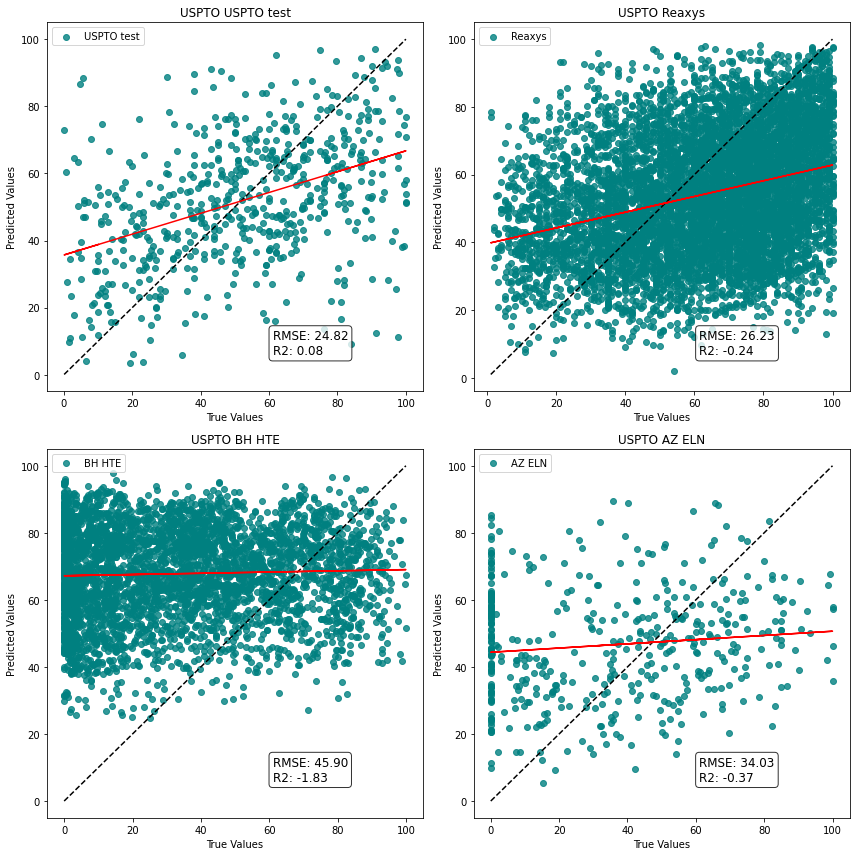

In [18]:
names = ['USPTO USPTO test', 'USPTO Reaxys', 'USPTO BH HTE', 'USPTO AZ ELN']
labels = ['USPTO test', 'Reaxys', 'BH HTE', 'AZ ELN']
X = [test_df_us, df_test_rx, df_test_hte, df_test_az]

# Create a figure and axis
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

for i, (name, l, x) in enumerate(zip(names, labels, X)):
    # Example y_predicted values for each model
    y_true, y_predicted = epochs_calc_r2(x, "uspto_no_dupl_100_ep_less_dr", 299, 1, 100,  1, mean, std)

    # Calculate the row and column indices for the current subplot
    row = i // 2
    col = i % 2

    # Call the plotting function for each model with the respective subplot
    plot_model(axs[row, col], y_true, y_predicted, name, l)

    # Set labels and title for each subplot
    axs[row, col].set_xlabel('True Values')
    axs[row, col].set_ylabel('Predicted Values')
    axs[row, col].set_title(f'{name}')

    # Add legend to each subplot
    axs[row, col].legend()
# Adjust spacing between subplots
plt.tight_layout()

# Save or show the plot
plt.savefig('publication_plot_hte_hte.png', dpi=300)  # Save the plot as an image file
plt.show()

In [31]:
df_hte = pd.read_csv('/projects/mai/users/kjkh840_varvara/yield_article/df_hte_bh_rxnfp_mhfp6_no_dupl.csv')
train_df_hte=df_hte.sample(frac=0.8,random_state=200)
val_test=df_hte.drop(train_df_hte.index)
val_df_hte = val_test.iloc[int(len(val_test)/2):]
test_df_hte = val_test.iloc[:int(len(val_test)/2)]

train_df_hte = train_df_hte[['rxn', 'YIELD']] 
test_df_hte = test_df_hte[['rxn', 'YIELD']] #
val_df_hte = val_df_hte[['rxn', 'YIELD']]

train_df_hte.columns = ['text', 'labels']
test_df_hte.columns = ['text', 'labels']
val_df_hte.columns = ['text', 'labels']


mean = train_df_hte.labels.mean()
std = train_df_hte.labels.std()

train_df_hte['labels'] = (train_df_hte['labels'] - mean) / std
test_df_hte['labels'] = (test_df_hte['labels'] - mean) / std
y_true, y_predicted = epochs_calc_r2(test_df_hte, "hte_40_ep_less_dr", 198, 1, 40,  1, mean, std)
#plot_model(axs[row, col], y_true, y_predicted, "BH HTE BH HTE test", "BH HTE")


Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


  0%|          | 0/395 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

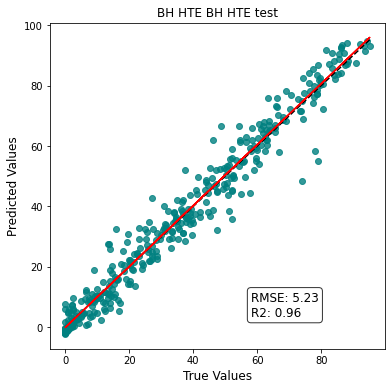

In [36]:
rmse = np.sqrt(mean_squared_error(y_true, y_predicted))
r2 = r2_score(y_true, y_predicted)
fig, ax = plt.subplots(figsize=(6, 6))
# Plot the data
ax.scatter(y_true, y_predicted, color='teal', label='BH HTE', alpha=0.8)

# Plot the diagonal line
ax.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='black', linestyle='--')

# Plot the fitting line
fitting_line = np.polyfit(y_true, y_predicted, 1)
ax.plot(y_true, np.polyval(fitting_line, y_true), color='r')

# Set labels and title
ax.set_xlabel('True Values', fontsize=12)
ax.set_ylabel('Predicted Values', fontsize=12)
ax.set_title(f'BH HTE BH HTE test')

# Display RMSE and R2 coefficients in the plot
text = f'RMSE: {rmse:.2f}\nR2: {r2:.2f}'
props = dict(boxstyle='round', facecolor='white', edgecolor='black', alpha=0.8)
ax.text(0.6, 0.1, text, transform=ax.transAxes, fontsize=12, bbox=props)

# Save or show the plot
plt.savefig('publication_plot_hte_hte_1.png', dpi=300)  # Save the plot as an image file
plt.show()

In [17]:
plt.tight_layout()
#plt.savefig('publication_plot.png', dpi=300)  # Save the plot as an image file
plt.show()

<Figure size 432x288 with 0 Axes>

In [ ]:
df = pd.read_csv(args.path_to_train_df)
testing_df = pd.read_csv(args.path_to_test_df)
        delimiter = '.'
        df['rxn'] = df.apply(lambda row: delimiter.join(row[['CONDITIONS', 'NO_MAP_NO_COND']]), axis=1)

        train_df=df.sample(frac=0.8,random_state=200)
        val_test=df.drop(train_df.index)
        val_df = val_test.iloc[int(len(val_test)/2):]
        test_df = val_test.iloc[:int(len(val_test)/2)]

        train_df = train_df[['rxn', 'YIELD']] 
        test_df = test_df[['rxn', 'YIELD']] #
        val_df = val_df[['rxn', 'YIELD']]

        train_df.columns = ['text', 'labels']
        test_df.columns = ['text', 'labels']
        val_df.columns = ['text', 'labels']
        
        
        mean = train_df.labels.mean()
        std = train_df.labels.std()

        train_df['labels'] = (train_df['labels'] - mean) / std
        test_df['labels'] = (test_df['labels'] - mean) / std
        val_df['labels'] = (val_df['labels'] - mean) / std
    
        if args.dataset_train == 'uspto':
            epochs_calc_r2(test_df, args.model_dir, args.dataset_train, args.dataset_test, 299, 1, int(args.final_epoch), 1, mean, std)
        elif args.dataset_train == 'reaxys':
            epochs_calc_r2(test_df, args.model_dir, args.dataset_train, args.dataset_test, 357,  1, int(args.final_epoch),  1, mean, std)
        elif args.dataset_train == 'hte':
            epochs_calc_r2(test_df, args.model_dir, args.dataset_train, args.dataset_test, 198,  1, int(args.final_epoch),  1, mean, std)
            


In [ ]:
    elif args.mode == 'test':
        delimiter = '.'
        df['rxn'] = df.apply(lambda row: delimiter.join(row[['CONDITIONS', 'NO_MAP_NO_COND']]), axis=1)
        testing_df['rxn'] = df.apply(lambda row: delimiter.join(row[['CONDITIONS', 'NO_MAP_NO_COND']]), axis=1)
        
        train_df=df.sample(frac=0.8,random_state=200)
        
        train_df = train_df[['rxn', 'YIELD']] 
        testing_df = testing_df[['rxn', 'YIELD']] #


        train_df.columns = ['text', 'labels']
        testing_df.columns = ['text', 'labels']
        testing_df = testing_df.dropna()
        mean = train_df.labels.mean()
        std = train_df.labels.std()

        train_df['labels'] = (train_df['labels'] - mean) / std
        testing_df['labels'] = (testing_df['labels'] - mean) / std
        
        if args.dataset_train == 'uspto':
            epochs_calc_r2(testing_df, args.model_dir, args.dataset_train, args.dataset_test, 299, 1, int(args.final_epoch),  1, mean, std)
        elif args.dataset_train == 'reaxys':
            epochs_calc_r2(testing_df, args.model_dir, args.dataset_train, args.dataset_test, 357,  1,  int(args.final_epoch), 1, mean, std)